# House prices regression

In [1]:
%matplotlib inline
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV


Using TensorFlow backend.
//anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.4/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Read the data
-  drop the id column for now as it's now useful  
-  remember the id column for the test data

In [2]:
#
train_data = pd.read_csv('train.csv').drop('Id',axis=1)
test_data = pd.read_csv('test.csv')

#
y_train = train_data['SalePrice']
y_train = np.log(y_train)

x_train_raw = train_data.drop('SalePrice',axis=1)

#
x_test_ids = test_data['Id']
x_test_raw = test_data.drop('Id',axis=1)

# 
#x_train_raw.dropna(thresh= len(x_train_raw)*0.90, axis=1,inplace=True)
#diff = set(x_test_raw.columns)-set(x_train_raw.columns)
#x_test_raw.drop(diff ,axis=1,inplace=True)

pd.set_option('display.max_columns', 500)
x_test_raw.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,LwQ,144,270,882,GasA,TA,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### Let's check out the features 

In [3]:
numerical_features = x_train_raw.columns[x_train_raw.dtypes != 'object']
categorical_features = x_train_raw.columns[x_train_raw.dtypes == 'object']

train_length = len(x_train_raw)
test_length = len(x_test_raw)
all_data = pd.concat([x_train_raw, x_test_raw])

print(len(x_train_raw))
print(len(x_test_raw))
print(len(all_data))

1460
1459
2919


### Transforming features 
- missing -> encode 
- categorical -> One hot encoding
- numerical -> scaling

In [4]:
all_data[numerical_features] = all_data[numerical_features].fillna(99999999)
all_data[categorical_features] = all_data[categorical_features].fillna("Missing")


In [5]:
all_data.head(20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65,8450,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Missing,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Missing,Missing,Missing,0,2,2008,WD,Normal
1,20,RL,80,9600,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Missing,Missing,Missing,0,5,2007,WD,Normal
2,60,RL,68,11250,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Missing,Missing,Missing,0,9,2008,WD,Normal
3,70,RL,60,9550,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Missing,Missing,Missing,0,2,2006,WD,Abnorml
4,60,RL,84,14260,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Missing,Missing,Missing,0,12,2008,WD,Normal
5,50,RL,85,14115,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,Missing,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,Missing,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75,10084,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,Missing,Missing,Missing,0,8,2007,WD,Normal
7,60,RL,99999999,10382,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,Missing,Missing,Shed,350,11,2009,WD,Normal
8,50,RM,51,6120,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,Missing,Missing,Missing,0,4,2008,WD,Abnorml
9,190,RL,50,7420,Pave,Missing,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex

In [6]:
ss = StandardScaler()
all_data[numerical_features] = ss.fit_transform(all_data[numerical_features])

all_data = pd.get_dummies(data=all_data, columns=categorical_features)



In [7]:
x_train = all_data.head(train_length)
x_test = all_data.tail(test_length)
print(len(x_train))
print(len(x_test))
print(len(all_data))

1460
1459
2919


### Building the Keras model
- simple architecture for a regression model
- relu activation function
- mean_squared_logarithmic_error is used as competition metric

In [8]:
"""

model = Sequential()
model.add(Dense(1024, input_dim= x_train.shape[1], init='normal', activation='relu'))
model.add(Dense(256, init='normal', activation='relu'))
model.add(Dense(64, init='normal', activation='relu'))
model.add(Dense(16, init='normal', activation='relu'))
model.add(Dense(1, init='normal'))

model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1)

#Save the model
from keras.models import load_model

model.save('model_house_prices.h5')  # creates a HDF5 file 'my_model.h5'

"""

"\n\nmodel = Sequential()\nmodel.add(Dense(1024, input_dim= x_train.shape[1], init='normal', activation='relu'))\nmodel.add(Dense(256, init='normal', activation='relu'))\nmodel.add(Dense(64, init='normal', activation='relu'))\nmodel.add(Dense(16, init='normal', activation='relu'))\nmodel.add(Dense(1, init='normal'))\n\nmodel.compile(loss='mean_squared_logarithmic_error', optimizer='adam')\nmodel.fit(x_train, y_train, epochs=100, batch_size=1)\n\n#Save the model\nfrom keras.models import load_model\n\nmodel.save('model_house_prices.h5')  # creates a HDF5 file 'my_model.h5'\n\n"

##  Stacking

In [9]:
'''
model1 = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05)
model2 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber')
model3 = GradientBoostingRegressor(n_estimators=1000,max_depth=10)
model4 = GradientBoostingRegressor(n_estimators=25,max_depth=50)
model5 = GradientBoostingRegressor(n_estimators=5000,max_depth=2,max_features='log2')

model6 = RandomForestRegressor(n_estimators = 100,max_features='auto',max_depth=100)
model7 = RandomForestRegressor(n_estimators = 1000,max_depth=10,min_samples_leaf=3)
model8 = RandomForestRegressor(n_estimators = 1000,max_depth=5,min_samples_leaf=2)
model9 = RandomForestRegressor(n_estimators = 1000,max_features='log2', max_depth=2)

model10 = SVR(kernel='linear')
model11 = Ridge(random_state=1)
model12 = Lasso(random_state=1)
model13 = SVR(kernel='rbf')
model14 = SVR(kernel='rbf',max_iter=10000)

model15 = ElasticNetCV(alphas=[0.0001], l1_ratio=[1], max_iter=10000)
model16 = ElasticNetCV(alphas=[ 1], l1_ratio=[.01], max_iter=10000)
model17 = ElasticNetCV(alphas=[0.001], l1_ratio=[ .5], max_iter=10000)
model18 = LinearRegression()

# averaging version
Final_labels = np.zeros([1459])
models = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10, model11,model12,model13,model14,model15,model16,model7,model8]
for model in models:
    model = model.fit(x_train, y_train)
    Final_labels += np.exp(model.predict(x_test))
Final_labels = Final_labels / float(18)


# stacking regression version
stack_regr1 = StackingRegressor(regressors=models, meta_regressor=GradientBoostingRegressor(n_estimators=1000000,learning_rate=0.01))
stack_regr2 = StackingRegressor(regressors=models, meta_regressor = SVR(kernel='rbf'))
stack_regr3 = StackingRegressor(regressors=models,meta_regressor=RandomForestRegressor(n_estimators = 10000,max_features='auto'))
stack_regr4 = StackingRegressor(regressors=[stack_regr1,stack_regr2,stack_regr3], meta_regressor = SVR(kernel='rbf'))

stack_regr4.fit(x_train, y_train)
'''


"\nmodel1 = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05)\nmodel2 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber')\nmodel3 = GradientBoostingRegressor(n_estimators=1000,max_depth=10)\nmodel4 = GradientBoostingRegressor(n_estimators=25,max_depth=50)\nmodel5 = GradientBoostingRegressor(n_estimators=5000,max_depth=2,max_features='log2')\n\nmodel6 = RandomForestRegressor(n_estimators = 100,max_features='auto',max_depth=100)\nmodel7 = RandomForestRegressor(n_estimators = 1000,max_depth=10,min_samples_leaf=3)\nmodel8 = RandomForestRegressor(n_estimators = 1000,max_depth=5,min_samples_leaf=2)\nmodel9 = RandomForestRegressor(n_estimators = 1000,max_features='log2', max_depth=2)\n\nmodel10 = SVR(kernel='linear')\nmodel11 = Ridge(random_state=1)\nmodel12 = Lasso(random_state=1)\nmodel13 = SVR(kernel='rbf')\nmodel14 = SVR(kernel='rbf',max_iter=10000)\n\nmodel15 = ElasticN

## XGBoost regressor Cross validation grid search

In [10]:
'''
est = GradientBoostingRegressor(loss='huber')


param_grid = [
  {'n_estimators': [10000],
   'learning_rate': [0.05, 0.02, 0.01],
    'min_samples_leaf': [3, 6],
    'max_depth': [3, 5], 
    'max_features': ['log2','sqrt','auto'], subsample = [0.7,0.8,0.9]}
 ]

gs_cv = GridSearchCV(est, param_grid, scoring='neg_mean_squared_error', n_jobs=4).fit(x_train, y_train)

gs_cv.best_params_


'''


"\nest = GradientBoostingRegressor(loss='huber')\n\n\nparam_grid = [\n  {'n_estimators': [10000],\n   'learning_rate': [0.05, 0.02, 0.01],\n    'min_samples_leaf': [3, 6],\n    'max_depth': [3, 5], \n    'max_features': ['log2','sqrt','auto'], subsample = [0.7,0.8,0.9]}\n ]\n\ngs_cv = GridSearchCV(est, param_grid, scoring='neg_mean_squared_error', n_jobs=4).fit(x_train, y_train)\n\ngs_cv.best_params_\n\n\n"

### XG Boost regressor with feature importances

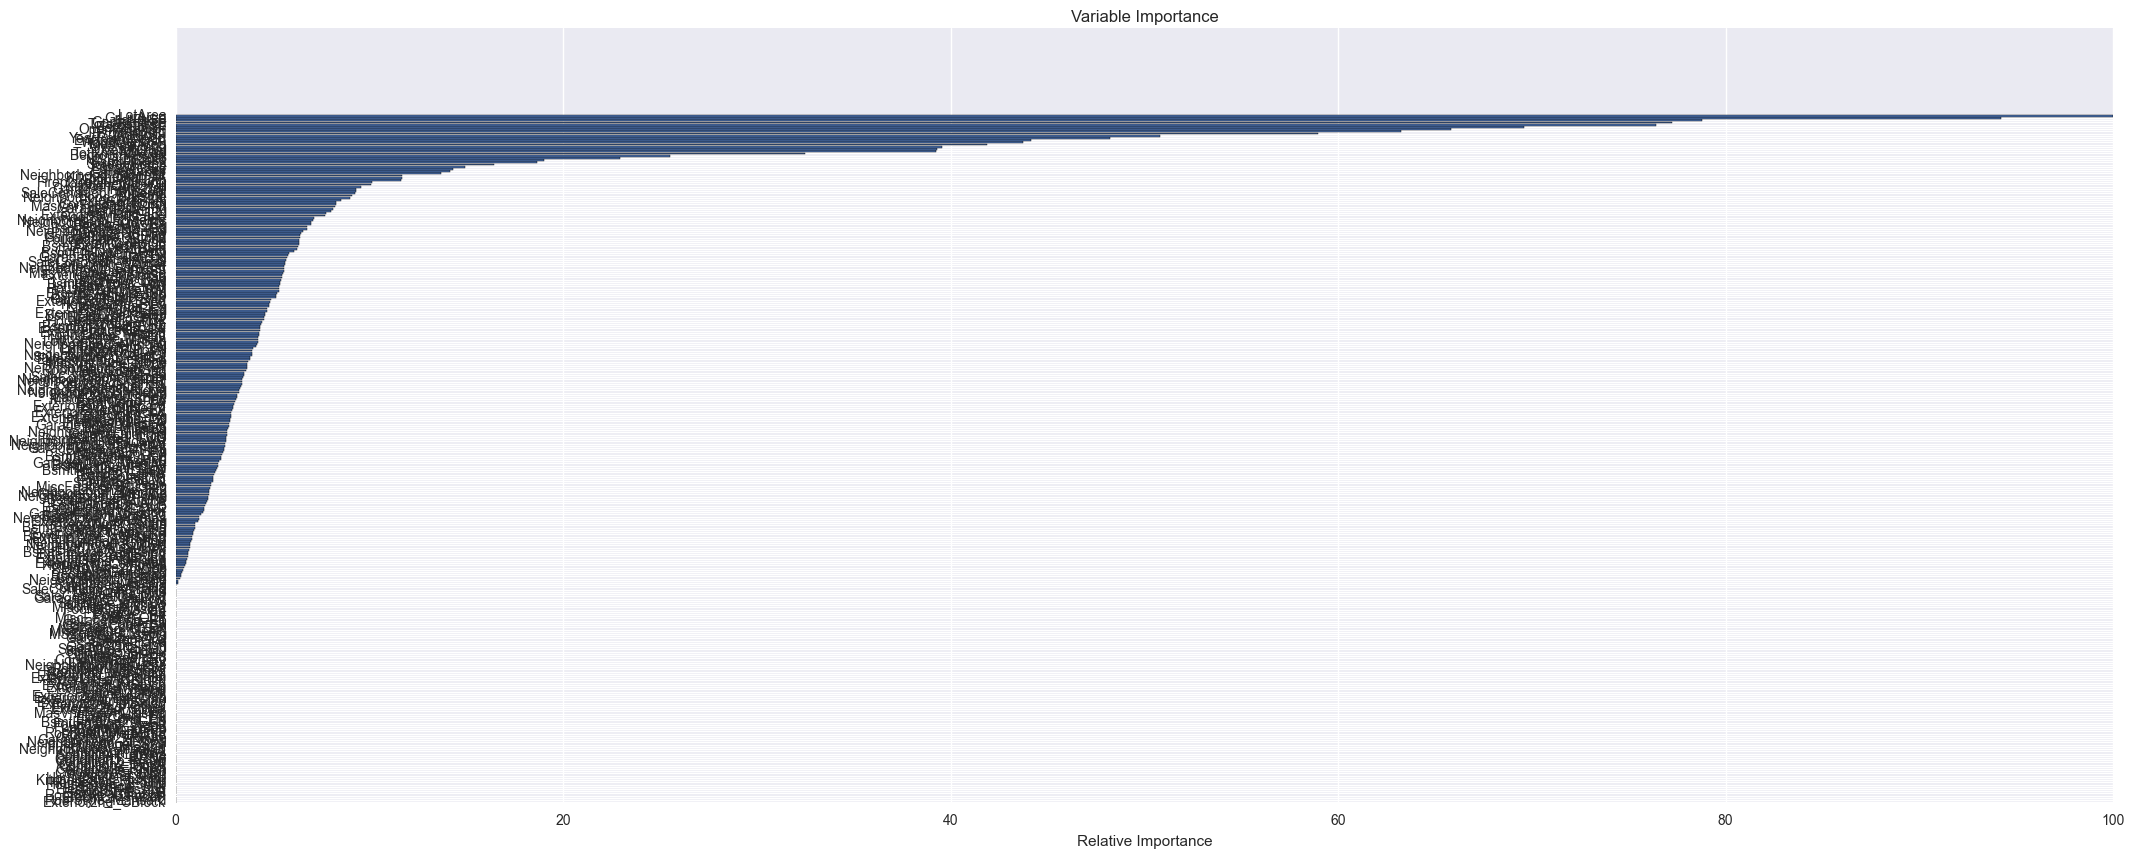

In [11]:

est = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)


feature_importance = est.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Write the submission 
    - you should be able to get around 0.12 score which would place you atleast into top 1/3 of the scores

In [12]:
y_test = np.exp(est.predict(x_test))

In [13]:
result = pd.DataFrame({'Id': x_test_ids.tolist(), 'SalePrice': y_test.ravel()})
result.to_csv('submission8.csv',index=False)